# King County Housing Regression Project

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ SCRUB](#SCRUB)**<br>
3 -**[ EXPLORE](#EXPLORE)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#Conclusions-&-Recommendations)<br>**
</font>
___

# INTRODUCTION

* Students: Cody Freese/Fennec Nightingale/Thomas Cornett
* Pace: Part time
* Instructor: Amber Yandow
* Blog post URL:

<p> What factors impact the price of a home?</p>
<p> What factors impact the price of a home for different income levels?</p>
<p> If you're looking to move your family to king county, where is the best bang for your buck?</p>

## Import Tools

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import mlxtend

In [2]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from math import sin, cos, sqrt, atan2, radians
from sklearn import svm
from scipy.stats import zscore
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Editing Our Settings 
We have too many columns to view normally, and it's difficult to get a good grasp of our data with how much is normally cut off. 


In [4]:
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# OBTAIN DATA
Here we'll be working with the King County housing data provided to us by FlatIron and data about schools in King County gathered by ArcGis. We'll be importing them via the Pandas library. 

In [5]:
#wrote up our data types to save on computer space and stop some of them from being inccorectly read as objs
kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

In [6]:
kc_data = pd.read_csv(r'~\Documents\Flatiron\data\data\kc_house_data.csv', parse_dates = ['date'], dtype=kc_dtypes)
schools = pd.read_csv(r'~\Documents\Flatiron\data\data\Schools.csv')

That's all of the data we need to start. Now we'll be adding the last of our data, calculating the distance between the schools and our homes. 

In [7]:
#calculate distance between schools and data 
kc = {}

# approximate radius of earth in miles  miles
i = 0
#iterate over each of our rows in the dataframe
while i <= 21480:
    R = 3963.0
    k = 0
    lat1 = radians(kc_data['lat'].iloc[i])
    lon1 = radians(kc_data['long'].iloc[i])
    distance = []
    #iterate over each school to see which school is the closest to each row in our datframe 
    while k <= 641:
        lat2 = radians(schools['LAT_CEN'].iloc[k])
        lon2 = radians(schools['LONG_CEN'].iloc[k])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance.append(R * c)
        
        k += 1 
    #sort schools by distance 
    distance.sort()
    #choose closest school 
    kc[i] = distance[0:1]
    i += 1

Now we turn those distances into a dataframe, so we can join them with the rest of our data and match them with the houses they belong to. 

In [8]:
kc1 = pd.DataFrame.from_dict(kc, orient='index', columns=['mi_nearest_scl'])

In [9]:
kc_data = kc_data.merge(kc1, left_index=True, right_index=True)

Now let's take a look at our data to see what we are working with and what we might need to fix 

In [10]:
kc_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,mi_nearest_scl
count,2.148100e+04,2.148100e+04,21481.000000,21481.000000,21481.000000,2.148100e+04,21481.000000,19120.000000,21419.000000,21481.000000,21481.000000,21481.000000,21481.000000,17668.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000
mean,-2.797762e+06,5.395128e+05,3.373260,2.112751,2078.656720,1.513524e+04,1.490527,0.007584,0.233858,3.411992,7.653554,1786.507518,1970.794470,84.048619,98077.920302,47.560076,-122.213877,1985.827848,12782.423910,0.485128
std,1.193631e+09,3.661981e+05,0.926217,0.767716,915.889131,4.148734e+04,0.537916,0.086756,0.765770,0.651594,1.171666,825.546338,29.316674,400.886787,53.539147,0.138700,0.140696,683.622890,27311.574331,0.463277
min,-2.145167e+09,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,0.004939
25%,-9.967670e+08,3.200000e+05,3.000000,1.500000,1430.000000,5.060000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.470400,-122.328000,1490.000000,5100.000000,0.245270
50%,2.423315e+07,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7627.000000,0.381372
75%,9.841334e+08,6.450000e+05,4.000000,2.500000,2550.000000,1.071400e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1996.000000,0.000000,98118.000000,47.678200,-122.125000,2360.000000,10091.000000,0.575124
max,2.147300e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,16.615246


In [11]:
kc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21481 entries, 0 to 21480
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              21481 non-null  int32         
 1   date            21481 non-null  datetime64[ns]
 2   price           21481 non-null  float64       
 3   bedrooms        21481 non-null  int32         
 4   bathrooms       21481 non-null  float64       
 5   sqft_living     21481 non-null  int32         
 6   sqft_lot        21481 non-null  int32         
 7   floors          21481 non-null  float64       
 8   waterfront      19120 non-null  float64       
 9   view            21419 non-null  float64       
 10  condition       21481 non-null  float64       
 11  grade           21481 non-null  int32         
 12  sqft_above      21481 non-null  int32         
 13  sqft_basement   21481 non-null  object        
 14  yr_built        21481 non-null  int32         
 15  yr

In [12]:
kc_data.isnull().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2361
view                62
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated      3813
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
mi_nearest_scl       0
dtype: int64

# SCRUB
Cleaning up our data, filling NaN values, dropping unnecessary columns 

In [13]:
kc_data = kc_data.drop(['id', 'date'], 1)

In [14]:
#to use sqft basment later on we need to convert it to a float 
kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float)

As we can see we have 3 columns with null values, after exploring them, it makes the most sense to fill the null values with zeros, which is what they had been using to indicate a column without anything anyways. 

In [15]:
kc_data = kc_data.fillna(0)

In [16]:
#Convert to integer for whole number year, not sure why it'll let us reassign it here but raise errors in dtypes
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

### Add Dummy Variables<p>
Catagorical columns needs to be transformed so we can use them in our model.</p>
<p>
thankfully, the Pandas library has got us covered with pd.get_dummies()</p>

In [17]:
# fixing condition to be a good or bad, hoping that'll help get rid of the multicolinearity 
kc_data['condition'] = kc_data.condition.replace(to_replace = [1.0, 2.0, 3.0, 4.0, 5.0],  value= ['bad', 'bad', 'good', 'good', 'good'])

In [18]:
#we have 70 zipcodes and 120 years, it would add too much complexity to our data to increase it by 190 columns
# so instead, we're going to go through and bin them! 
zips = []
years = []


for zipcode in kc_data.zipcode:
    zips.append(zipcode)
for year in kc_data.yr_built:
    years.append(year)
    
zips = list(set(zips))
years = list(set(years))

zips.sort()
years.sort()

In [19]:
#will have to find a way to write this into a loop at some point, but, I can't figure out how to get .replace()
#to adequatley read lists of lists while also giving them unique names, so for now this works 
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[0:5],  value= 'zip001t005')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[5:10], value= 'zip006t011')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[10:15], value= 'zip014t024')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[15:20], value= 'zip027t031')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[20:25], value= 'zip032t039')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[25:30], value= 'zip040t053')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[30:35], value= 'zip055t065')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[35:40], value= 'zip070t077')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[40:45], value= 'zip092t106')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[45:50], value= 'zip107t115')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[50:55], value= 'zip116t122')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[55:60], value= 'zip125t144')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[60:65], value= 'zip146t168')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[65:70], value= 'zip177t199')

In [20]:
#gonna do the same for year built by 20 years, will give us 6 new columns, may be illuminating 
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[0:20], value= 'thru20')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[20:40], value= 'thru40')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[40:60], value= 'thru60')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[60:80], value= 'thru80')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[80:100], value= 'thru2000')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[100:120], value= 'thru2020')

In [21]:
# get dummies of our new variables 
dummys = ['zipcode', 'yr_built', 'condition', ]

for dummy in dummys:
    dumm = pd.get_dummies(kc_data[dummy], drop_first=True)
    kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

#we're doing something unique to these variables so it wouldn't save us any time to put them into a loop
dumm = pd.get_dummies(kc_data['view'], prefix='view', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['grade'], prefix='gra', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [22]:
#break up variables into diverse ranges & renaming our dummies so that they'r easier to interpret 
kc_data = kc_data.rename({'view_1.0': 'view1', 'view_2.0': 'view2', 'view_3.0': 'view3', 'view_4.0':'view4'},axis=1)
kc_data = kc_data.rename({'gra_4': 'D', 'gra_5':'Cmin', 'gra_6':'C','gra_7':'Cpl', 'gra_8':'Bmin', 'gra_9':'B',
                          'gra_10':'Bpl', 'gra_11':'Amin', 'gra_12':'A', 'gra_13':'Apl'},axis=1)

# EXPLORE

Now that we have all of the data we'll need ready to go we can really start digging in and checking it out! 

## Histogram

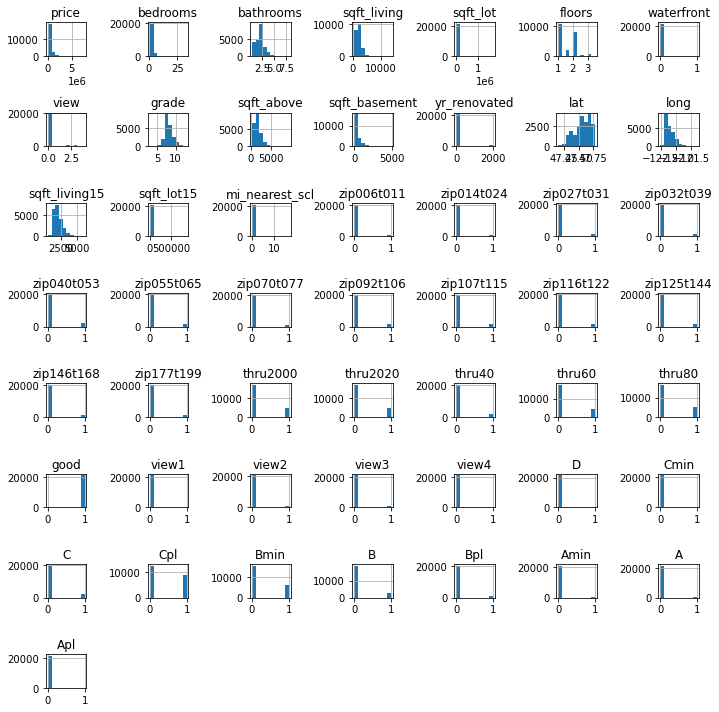

In [23]:
kc_data.hist(figsize=(10,10))
plt.tight_layout()

## Scatter Matrix

In [24]:
# fig = pd.plotting.scatter_matrix(kc_data,figsize=(16,16));

## Heatmap

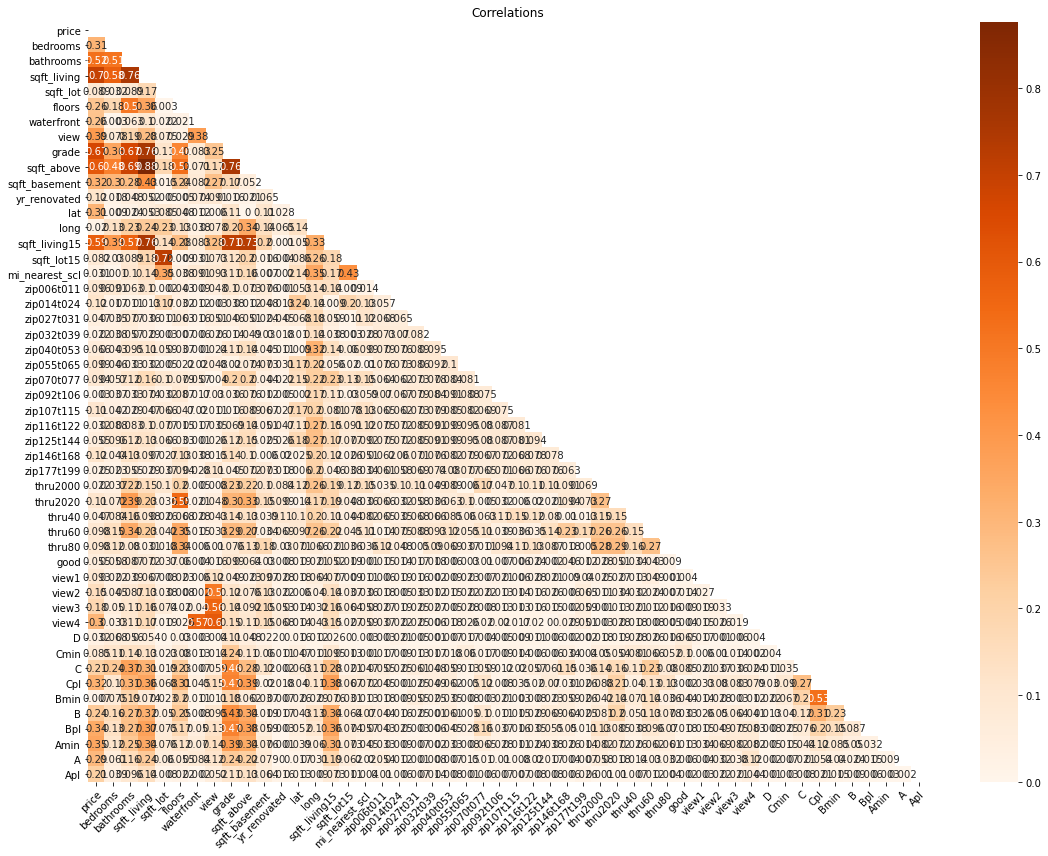

In [25]:
fig, ax = plt.subplots(figsize=(16,12))
corr = kc_data.corr().abs().round(3)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='Oranges', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')
fig.tight_layout()

We can see some colinearity between our features, it's best to either remove or transform them if we want to use them in our model

If we were to multiply by basement to try and get rid of the correlation, we'd be multiplying by a bunch of zeros and it wouldn't adequetly represent our data. By adding one to every 'sqft_basement' that is equal to zero, when we multiply if there are no basement values we still keep our 'sqft_above' values. 

In [26]:
kc_data['sqft_basement'] = kc_data['sqft_basement'].map(lambda x :  1 if x == 0 else x )

In [27]:
#getting rid of multicolinearity in sqftage 
kc_data['sqft_total'] = kc_data['sqft_living']*kc_data['sqft_lot']
kc_data['sqft_neighb'] = kc_data['sqft_living15']*kc_data['sqft_lot15']
kc_data['sqft_habitable'] = kc_data['sqft_above']*kc_data['sqft_basement']

In [28]:
#print columns we will be using going forward 
#make a copy of the dataframe holding only columns we'll be including
kc_data.columns
all_data = kc_data.copy()
kc_data = kc_data[['price', 'bedrooms', 'bathrooms', 'floors','waterfront', 
                   'yr_renovated', 'lat', 'long', 
                   'sqft_total', 'sqft_neighb', 'sqft_habitable', 
                   'good', 'view1', 'view2', 'view3', 'view4', 
                   'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 
                   'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
                   'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
                   'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
                   'zip177t199', 
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
                   'mi_nearest_scl']].copy()

# MODEL

## Initial Model on Price

In [29]:
lowtier = kc_data[kc_data.price <=300000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
hightier = kc_data[kc_data.price >800000]

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_nearest_scl']

mediumincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_nearest_scl']

highincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_nearest_scl']

In [30]:
def make_ols(df, x_columns, drops=None, target='price', add_constant=False):
    if drops:
        drops.append(target)
        X = df.drop(columns=drops)
    else:
        X = df[x_columns]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X)
    model = ols.fit()
    display(model.summary())
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', alpha=.05, fit=True)
    return model

In [31]:
price_tiers = [('low', lowtier, lowincome), 
               ('mid', midtier, mediumincome), 
               ('high', hightier, highincome)]

LOW


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              5039.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        21:57:06   Log-Likelihood:                         -54289.
No. Observations:                4556   AIC:                                  1.087e+05
Df Residuals:                    4516   BIC:                                  1.089e+05
Df Model:                          40                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        4862.1402    850.891      5.714      0.000    3193.978    6530.303
bathrooms       1.902e+04   1459.387     13.034      0.000    1.62e+04    2.19e+04
floors          2045.7135   1884.947      1.085      0.278   -1649.705    5741.132
waterfront      4.187e+04   3.18e+04      1.317      0.188   -2.04e+04    1.04e+05
yr_renovated       1.3752      1.949      0.705      0.481      -2.446       5.197
lat              7.65e+04   5666.413     13.500      0.000    6.54e+04    8.76e+04
long            2.796e+04   2202.839     12.694      0.000    2.36e+04    3.23e+04
sqft_total      9.244e-05   2.24e-05      4.120      0.000    4.85e-05       0.000
sqft_neighb     2.484e-05   2.26e-05      1.101      0.271   -1.94e-05    6.91e-05
sqft_habitable     0.0117      0.002      6.279      0.000       0.008       0.015
good            3.509e+04   3636.538      9.649      0.000     2.8e+04    4.22e+04
view1           3.186e+04   1.02e+04      3.123      0.002    1.19e+04    5.19e+04
view2           1.896e+04   5097.773      3.719      0.000    8963.589     2.9e+04
view3             2.3e+04   1.05e+04      2.181      0.029    2327.497    4.37e+04
view4           4.535e+04   3.02e+04      1.501      0.133   -1.39e+04    1.05e+05
D              -1.141e+05   3.74e+04     -3.055      0.002   -1.87e+05   -4.09e+04
Cmin           -9.724e+04   3.66e+04     -2.656      0.008   -1.69e+05   -2.55e+04
C              -7.387e+04   3.65e+04     -2.021      0.043   -1.46e+05   -2223.190
Cpl            -5.795e+04   3.66e+04     -1.584      0.113    -1.3e+05    1.38e+04
Bmin             -4.6e+04   3.66e+04     -1.256      0.209   -1.18e+05    2.58e+04
B              -5.026e+04   3.75e+04     -1.339      0.181   -1.24e+05    2.33e+04
Bpl            -3.206e-10    1.5e-10     -2.133      0.033   -6.15e-10   -2.59e-11
Amin           -2.747e-10   1.06e-10     -2.587      0.010   -4.83e-10   -6.66e-11
zip006t011      8512.3475   5574.040      1.527      0.127   -2415.500    1.94e+04
zip014t024      3271.9612   2191.294      1.493      0.135   -1024.047    7567.969
zip027t031      6610.3913   2577.146      2.565      0.010    1557.923    1.17e+04
zip032t039      5270.2441   2626.685      2.006      0.045     120.655    1.04e+04
zip040t053      3314.7976   2592.060      1.279      0.201   -1766.909    8396.504
zip055t065      1.294e+04   2485.484      5.205      0.000    8064.787    1.78e+04
zip070t077      3.546e+04   7907.708      4.485      0.000       2e+04     5.1e+04
zip092t106      9652.4968   2603.615      3.707      0.000    4548.137    1.48e+04
zip107t115      8342.7672   4816.964      1.732      0.083   -1100.839    1.78e+04
zip116t122      1.263e+04   3553.521      3.555      0.000    5665.711    1.96e

MID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              9393.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        21:57:07   Log-Likelihood:                     -1.8045e+05
No. Observations:               14007   AIC:                                  3.610e+05
Df Residuals:                   13965   BIC:                                  3.613e+05
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        1.023e+04   1061.875      9.638      0.000    8152.787    1.23e+04
bathrooms       3.452e+04   1933.055     17.859      0.000    3.07e+04    3.83e+04
floors          6638.4097   2287.076      2.903      0.004    2155.435    1.11e+04
waterfront      7.919e+04   1.96e+04      4.048      0.000    4.08e+04    1.18e+05
yr_renovated       0.9265      2.522      0.367      0.713      -4.016       5.869
lat             3.662e+05   7376.733     49.642      0.000    3.52e+05    3.81e+05
long             7.94e+04   9372.110      8.472      0.000     6.1e+04    9.78e+04
sqft_total      6.918e-05   1.22e-05      5.677      0.000    4.53e-05    9.31e-05
sqft_neighb        0.0001   1.89e-05      6.356      0.000    8.32e-05       0.000
sqft_habitable     0.0136      0.001      9.446      0.000       0.011       0.016
good            1.863e+04   1.05e+04      1.766      0.077   -2047.168    3.93e+04
view1           6.838e+04   6909.463      9.896      0.000    5.48e+04    8.19e+04
view2           5.233e+04   4205.469     12.443      0.000    4.41e+04    6.06e+04
view3            7.07e+04   6369.977     11.099      0.000    5.82e+04    8.32e+04
view4           1.006e+05   1.29e+04      7.818      0.000    7.54e+04    1.26e+05
D              -7.351e+06    1.2e+06     -6.144      0.000    -9.7e+06   -5.01e+06
Cmin           -7.318e+06    1.2e+06     -6.119      0.000   -9.66e+06   -4.97e+06
C              -7.339e+06    1.2e+06     -6.136      0.000   -9.68e+06   -4.99e+06
Cpl             -7.28e+06    1.2e+06     -6.086      0.000   -9.62e+06   -4.94e+06
Bmin           -7.209e+06    1.2e+06     -6.027      0.000   -9.55e+06   -4.86e+06
B              -7.118e+06    1.2e+06     -5.951      0.000   -9.46e+06   -4.77e+06
Bpl            -7.054e+06    1.2e+06     -5.897      0.000    -9.4e+06   -4.71e+06
Amin           -7.021e+06    1.2e+06     -5.868      0.000   -9.37e+06   -4.68e+06
zip006t011     -1.339e+04   6114.474     -2.190      0.029   -2.54e+04   -1406.337
zip014t024     -1.185e+05   6725.622    -17.621      0.000   -1.32e+05   -1.05e+05
zip027t031     -5.671e+04   5973.124     -9.494      0.000   -6.84e+04    -4.5e+04
zip032t039     -5.525e+04   5905.508     -9.356      0.000   -6.68e+04   -4.37e+04
zip040t053     -2.155e+04   6008.942     -3.586      0.000   -3.33e+04   -9767.413
zip055t065     -6.628e+04   5780.777    -11.466      0.000   -7.76e+04    -5.5e+04
zip070t077     -3.297e+04   6215.030     -5.305      0.000   -4.52e+04   -2.08e+04
zip092t106     -4.442e+04   6010.751     -7.391      0.000   -5.62e+04   -3.26e+04
zip107t115     -1.722e+04   6165.148     -2.792      0.005   -2.93e+04   -5130.495
zip116t122     -2.121e+04   5924.183     -3.580      0.000   -3.28e+04   -9597.

HIGH


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              951.2
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        21:57:07   Log-Likelihood:                         -41408.
No. Observations:                2918   AIC:                                  8.290e+04
Df Residuals:                    2878   BIC:                                  8.314e+04
Df Model:                          40                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms       -2833.5133   8662.559     -0.327      0.744   -1.98e+04    1.42e+04
bathrooms       1.103e+05    1.2e+04      9.220      0.000    8.68e+04    1.34e+05
floors           5.18e+04   1.77e+04      2.924      0.003    1.71e+04    8.65e+04
waterfront      6.635e+05    4.4e+04     15.064      0.000    5.77e+05     7.5e+05
yr_renovated      12.7639     12.843      0.994      0.320     -12.418      37.946
lat            -2.274e+05    1.1e+05     -2.064      0.039   -4.43e+05   -1.13e+04
long           -1.056e+05   4.29e+04     -2.460      0.014    -1.9e+05   -2.14e+04
sqft_total      3.165e-05   4.34e-05      0.730      0.466   -5.34e-05       0.000
sqft_neighb       -0.0002   7.88e-05     -2.546      0.011      -0.000   -4.61e-05
sqft_habitable     0.0571      0.004     14.649      0.000       0.049       0.065
good           -1.111e+04   1.47e+05     -0.076      0.940   -2.99e+05    2.77e+05
view1           9.723e+04   3.44e+04      2.824      0.005    2.97e+04    1.65e+05
view2           6.124e+04   2.21e+04      2.771      0.006    1.79e+04    1.05e+05
view3           1.253e+05   2.57e+04      4.876      0.000    7.49e+04    1.76e+05
view4           2.389e+05   3.18e+04      7.505      0.000    1.76e+05    3.01e+05
D              -5.327e-06   4.64e-07    -11.488      0.000   -6.24e-06   -4.42e-06
Cmin           -3.232e-06   2.81e-07    -11.493      0.000   -3.78e-06   -2.68e-06
C              -1.229e+06   1.18e+05    -10.422      0.000   -1.46e+06   -9.98e+05
Cpl            -1.244e+06   5.34e+04    -23.280      0.000   -1.35e+06   -1.14e+06
Bmin           -1.131e+06    4.5e+04    -25.124      0.000   -1.22e+06   -1.04e+06
B              -9.909e+05   4.19e+04    -23.665      0.000   -1.07e+06   -9.09e+05
Bpl            -7.972e+05   4.06e+04    -19.636      0.000   -8.77e+05   -7.18e+05
Amin           -5.621e+05   4.16e+04    -13.523      0.000   -6.44e+05   -4.81e+05
zip006t011     -4.035e+05   3.05e+04    -13.225      0.000   -4.63e+05   -3.44e+05
zip014t024     -3.495e+05    8.3e+04     -4.211      0.000   -5.12e+05   -1.87e+05
zip027t031     -5.288e+05   4.27e+04    -12.379      0.000   -6.13e+05   -4.45e+05
zip032t039     -8.715e+04   3.11e+04     -2.801      0.005   -1.48e+05   -2.61e+04
zip040t053     -2.759e+05   2.75e+04    -10.017      0.000    -3.3e+05   -2.22e+05
zip055t065     -6.135e+05   4.97e+04    -12.332      0.000   -7.11e+05   -5.16e+05
zip070t077     -4.471e+05    3.1e+04    -14.438      0.000   -5.08e+05   -3.86e+05
zip092t106     -2.657e+05   3.49e+04     -7.621      0.000   -3.34e+05   -1.97e+05
zip107t115      -1.87e+05   3.15e+04     -5.941      0.000   -2.49e+05   -1.25e+05
zip116t122     -3.836e+05   3.38e+04    -11.367      0.000    -4.5e+05   -3.17e

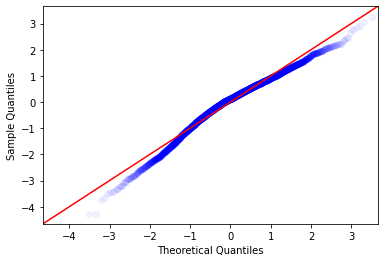

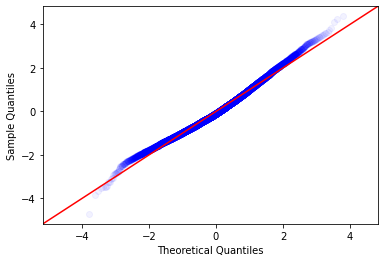

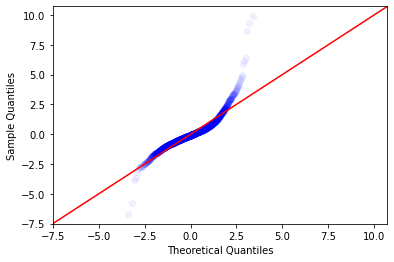

In [32]:
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

## Refinement
First we're going to start filtering out outliers, helping normalize our data should improve our model 

In [33]:
for col in ['price']:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std()
    kc_data = kc_data.loc[kc_data[col_zscore] < 2]
    kc_data = kc_data.loc[kc_data[col_zscore] > (-2)]
    kc_data = kc_data.drop(col_zscore, axis = 1)

In [1]:
plt.figure(figsize=(15,4), alpha=.75)
plt.plot(kc_data['price'].value_counts().sort_index())

NameError: name 'plt' is not defined

In [35]:
for i in range(1,100):
    q = i / 100
    print('{} percentile: {}'.format(q, kc_data['price'].quantile(q=q)))

0.01 percentile: 152500.0
0.02 percentile: 175000.0
0.03 percentile: 190000.0
0.04 percentile: 200000.0
0.05 percentile: 210000.0
0.06 percentile: 217459.0
0.07 percentile: 225000.0
0.08 percentile: 230000.0
0.09 percentile: 237501.53999999998
0.1 percentile: 244150.0000000001
0.11 percentile: 249900.0
0.12 percentile: 252840.00000000003
0.13 percentile: 258478.55
0.14 percentile: 263971.0
0.15 percentile: 269000.0
0.16 percentile: 273071.04
0.17 percentile: 278000.0
0.18 percentile: 281270.0
0.19 percentile: 287500.0
0.2 percentile: 292030.0
0.21 percentile: 299000.0
0.22 percentile: 300000.0
0.23 percentile: 306095.00000000023
0.24 percentile: 311572.0
0.25 percentile: 316000.0
0.26 percentile: 320000.0
0.27 percentile: 325000.0
0.28 percentile: 330000.0
0.29 percentile: 335000.0
0.3 percentile: 340000.0
0.31 percentile: 345000.0
0.32 percentile: 350000.0
0.33 percentile: 352800.0
0.34 percentile: 358000.0
0.35 percentile: 362500.0
0.36 percentile: 369171.19999999995
0.37 percentile:

In [36]:
#in bedrooms, we can clearly see a single outlier that is likely just a typo 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so we will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [37]:
# to fix other outliers we will explore our data and find cutoffs that seem reasonable 
kc_data = kc_data.loc[kc_data['sqft_total'] <= 1.000000e+09] 
kc_data = kc_data.loc[kc_data['sqft_total'] >= 400000]
kc_data = kc_data.loc[kc_data['sqft_neighb'] <= 1.000000e+09]
kc_data = kc_data.loc[kc_data['sqft_habitable'] >= 400000]
kc_data = kc_data.loc[kc_data['sqft_habitable'] <= 1.000000e+07]
kc_data =  kc_data.loc[kc_data['bathrooms'] >= 1]
kc_data =  kc_data.loc[kc_data['bathrooms'] <= 5]
kc_data =  kc_data.loc[kc_data['bedrooms'] <= 7]
all_data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_renovated,lat,long,sqft_living15,sqft_lot15,mi_nearest_scl,zip006t011,zip014t024,zip027t031,zip032t039,zip040t053,zip055t065,zip070t077,zip092t106,zip107t115,zip116t122,zip125t144,zip146t168,zip177t199,thru2000,thru2020,thru40,thru60,thru80,good,view1,view2,view3,view4,D,Cmin,C,Cpl,Bmin,B,Bpl,Amin,A,Apl,sqft_total,sqft_neighb,sqft_habitable
count,2.148100e+04,21481.000000,21481.000000,21481.000000,2.148100e+04,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,21481.000000,2.148100e+04,2.148100e+04,2.148100e+04
mean,5.395128e+05,3.373260,2.112751,2078.656720,1.513524e+04,1.490527,0.006750,0.233183,7.653554,1786.507518,286.723197,69.129510,47.560076,-122.213877,1985.827848,12782.423910,0.485128,0.056469,0.052325,0.071505,0.080909,0.093804,0.088031,0.064336,0.074717,0.065500,0.086076,0.085890,0.061077,0.058005,0.210093,0.216051,0.080164,0.196080,0.230110,0.990736,0.015362,0.044225,0.023509,0.014711,0.001257,0.011266,0.094828,0.416833,0.279968,0.120711,0.052186,0.018202,0.004097,0.000605,3.564215e+07,2.878986e+07,4.933465e+05
std,3.661981e+05,0.926217,0.767716,915.889131,4.148734e+04,0.537916,0.081883,0.764767,1.171666,825.546338,439.697986,364.983982,0.138700,0.140696,683.622890,27311.574331,0.463277,0.230830,0.222687,0.257673,0.272701,0.291562,0.283347,0.245356,0.262941,0.247411,0.280483,0.280208,0.239477,0.233758,0.407384,0.411559,0.271553,0.397039,0.420913,0.095805,0.122992,0.205600,0.151517,0.120395,0.035432,0.105543,0.292984,0.493046,0.448994,0.325799,0.222406,0.133685,0.063875,0.024594,1.081329e+08,7.034390e+07,1.037308e+06
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,3.000000,370.000000,1.000000,0.000000,47.155900,-122.519000,399.000000,651.000000,0.004939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.965487e+09,6.965700e+05,3.700000e+02
25%,3.200000e+05,3.000000,1.500000,1430.000000,5.060000e+03,1.000000,0.000000,0.000000,7.000000,1190.000000,1.000000,0.000000,47.470400,-122.328000,1490.000000,5100.000000,0.245270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.418300e+06,8.569000e+06,1.550000e+03
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,7.000000,1560.000000,1.000000,0.000000,47.571800,-122.230000,1840.000000,7627.000000,0.381372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.418400e+07,1.370018e+07,2.660000e+03
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.071400e+04,2.000000,0.000000,0.000000,8.000000,2210.000000,550.000000,0.000000,47.678200,-122.125000,2360.000000,10091.000000,0.575124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

# The Final Model

In [151]:
lowtier = kc_data[(kc_data.price >= 210000) & (kc_data.price <= 348000) ]
midtier = kc_data[(kc_data.price >= 348000) & (kc_data.price <= 480000) ]
uppermidtier = kc_data[(kc_data.price >= 480000) & (kc_data.price <= 640000) ]
hightier = kc_data[(kc_data.price >= 640000) & (kc_data.price <= 900000)]

In [173]:
lowincome = ['bathrooms', 'lat', 'long',  'sqft_habitable', 
             'view1', 'view2', 'view3', 'Cpl', 'Bmin', 'B', 
             'Bpl', 'Amin', 'zip055t065', 'zip092t106',
             'zip107t115', 'zip146t168']

mediumincome = ['bathrooms', 'lat', 'long', 
                'view2', 'Bmin', 'B', 'Bpl', 
                'zip006t011', 'zip032t039', 'zip040t053', 
                'zip070t077',  'zip107t115', 'zip116t122', 
                'zip125t144', 'thru2000', 'thru80']

uppermedincome = ['bathrooms', 'long', 'sqft_habitable',
                  'Cpl', 'Bmin', 'B', 'Bpl',
                  'zip014t024', 'zip146t168', 
                  'zip125t144', 
                  'thru2000', 'thru2020', 'thru80']

highincome = ['bathrooms', 'floors', 'sqft_neighb', 
              'sqft_habitable', 'thru2020',
              'zip006t011', 'zip107t115',
              'zip116t122', 'zip177t199']

In [174]:
price_tiers = [('low', lowtier, lowincome), 
               ('mid', midtier, mediumincome), 
               ('upmid', uppermidtier, uppermedincome),
               ('high', hightier, highincome)]

LOW


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              7395.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:42:01   Log-Likelihood:                         -14112.
No. Observations:                1201   AIC:                                  2.825e+04
Df Residuals:                    1187   BIC:                                  2.832e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       5516.5803   1808.047      3.051      0.002    1969.257    9063.904
lat              1.14e+05   8071.127     14.119      0.000    9.81e+04     1.3e+05
long            4.225e+04   3135.618     13.475      0.000    3.61e+04    4.84e+04
sqft_habitable     0.0196      0.002      8.221      0.000       0.015       0.024
view1           3.119e+04   9370.099      3.328      0.001    1.28e+04    4.96e+04
view2           1.406e+04   5386.845      2.610      0.009    3490.485    2.46e+04
view3           2.716e+04   1.04e+04      2.621      0.009    6829.594    4.75e+04
Cpl              1.03e+04   3304.570      3.117      0.002    3817.932    1.68e+04
Bmin            2.484e+04   4070.133      6.103      0.000    1.69e+04    3.28e+04
B               3.386e+04   1.22e+04      2.780      0.006    9964.777    5.78e+04
Bpl             1.612e-10   6.35e-11      2.540      0.011    3.67e-11    2.86e-10
Amin            3.849e-11   1.42e-11      2.711      0.007    1.06e-11    6.63e-11
zip055t065      1.642e+04   2749.620      5.973      0.000     1.1e+04    2.18e+04
zip092t106      1.426e+04   3813.102      3.741      0.000    6782.612    2.17e+04
zip107t115      2.405e+04   5771.464      4.167      0.000    1.27e+04    3.54e+04
zip146t168      9441.6758   2987.861      3.160      0.002    3579.598    1.53e+04
==============================================================================
Omnibus:                       11.464   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                8.690
Skew:                          -0.104   Prob(JB):                       0.0130
Kurtosis:                       2.639   Cond. No.                     2.01e+23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.82e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

MID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.346e+04
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:42:01   Log-Likelihood:                         -18246.
No. Observations:                1535   AIC:                                  3.652e+04
Df Residuals:                    1519   BIC:                                  3.661e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms   7766.6120   1792.568      4.333      0.000    4250.442    1.13e+04
lat         7.781e+04   7810.997      9.962      0.000    6.25e+04    9.31e+04
long        2.708e+04   3044.020      8.895      0.000    2.11e+04     3.3e+04
view2       1.727e+04   4429.066      3.900      0.000    8586.686     2.6e+04
Bmin        1.467e+04   2169.627      6.760      0.000    1.04e+04    1.89e+04
B           3.104e+04   5772.741      5.376      0.000    1.97e+04    4.24e+04
Bpl         4.993e+04   1.06e+04      4.709      0.000    2.91e+04    7.07e+04
zip006t011  2.425e+04   4216.439      5.751      0.000     1.6e+04    3.25e+04
zip032t039  2.114e+04   3415.523      6.190      0.000    1.44e+04    2.78e+04
zip040t053  1.306e+04   4656.607      2.804      0.005    3925.383    2.22e+04
zip070t077  1.632e+04   4446.410      3.670      0.000    7597.592     2.5e+04
zip107t115  1.296e+04   4329.081      2.994      0.003    4469.115    2.15e+04
zip116t122  1.479e+04   3561.124      4.154      0.000    7806.968    2.18e+04
zip125t144  8092.8336   2637.826      3.068      0.002    2918.667    1.33e+04
thru2000   -1.209e+04   2978.917     -4.059      0.000   -1.79e+04   -6248.236
thru80     -1.191e+04   2217.646     -5.373      0.000   -1.63e+04   -7564.794
==============================================================================
Omnibus:                      119.816   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.318
Skew:                          -0.086   Prob(JB):                     1.07e-09
Kurtosis:                       2.215   Cond. No.                     1.58e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

UPMID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          2.040e+04
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:42:01   Log-Likelihood:                         -20085.
No. Observations:                1659   AIC:                                  4.020e+04
Df Residuals:                    1646   BIC:                                  4.027e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       9046.9032   2260.467      4.002      0.000    4613.208    1.35e+04
long           -4196.4793     70.152    -59.820      0.000   -4334.076   -4058.882
sqft_habitable     0.0059      0.002      3.139      0.002       0.002       0.010
Cpl              2.36e+04   7886.502      2.993      0.003    8131.809    3.91e+04
Bmin            3.914e+04   8126.985      4.816      0.000    2.32e+04    5.51e+04
B               4.868e+04   9235.425      5.271      0.000    3.06e+04    6.68e+04
Bpl             4.205e+04    1.3e+04      3.240      0.001    1.66e+04    6.75e+04
zip014t024     -2.215e+04   9655.946     -2.294      0.022   -4.11e+04   -3215.317
zip146t168     -1.559e+04   5095.809     -3.060      0.002   -2.56e+04   -5597.091
zip125t144     -1.028e+04   3467.292     -2.965      0.003   -1.71e+04   -3479.168
thru2000       -2.618e+04   3876.016     -6.754      0.000   -3.38e+04   -1.86e+04
thru2020       -2.309e+04   4803.946     -4.807      0.000   -3.25e+04   -1.37e+04
thru80         -2.238e+04   2808.189     -7.969      0.000   -2.79e+04   -1.69e+04
==============================================================================
Omnibus:                      255.993   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.914
Skew:                           0.066   Prob(JB):                     5.93e-14
Kurtosis:                       2.071   Cond. No.                     2.20e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

HIGH


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              3366.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:42:01   Log-Likelihood:                         -18016.
No. Observations:                1347   AIC:                                  3.605e+04
Df Residuals:                    1338   BIC:                                  3.610e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.624e+05   6975.040     23.284      0.000    1.49e+05    1.76e+05
floors          1.763e+05   1.03e+04     17.169      0.000    1.56e+05    1.96e+05
sqft_neighb        0.0011      0.000      5.795      0.000       0.001       0.001
sqft_habitable     0.0177      0.006      3.037      0.002       0.006       0.029
thru2020       -1.868e+05   1.37e+04    -13.667      0.000   -2.14e+05    -1.6e+05
zip006t011      6.599e+04   1.53e+04      4.322      0.000     3.6e+04    9.59e+04
zip107t115      1.038e+05   1.29e+04      8.060      0.000    7.86e+04    1.29e+05
zip116t122      8.643e+04   1.26e+04      6.845      0.000    6.17e+04    1.11e+05
zip177t199      1.249e+05   1.51e+04      8.277      0.000    9.53e+04    1.55e+05
==============================================================================
Omnibus:                       49.386   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.486
Skew:                          -0.460   Prob(JB):                     1.47e-12
Kurtosis:                       3.351   Cond. No.                     1.38e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.38e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

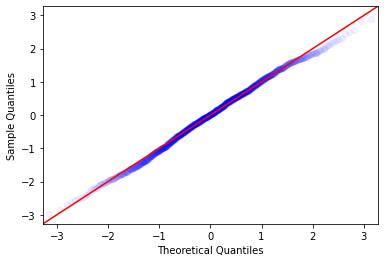

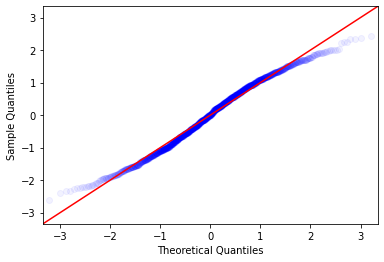

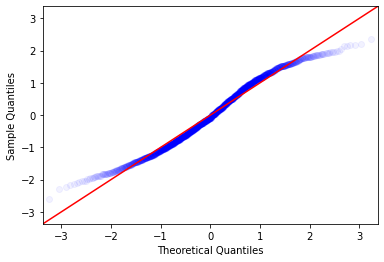

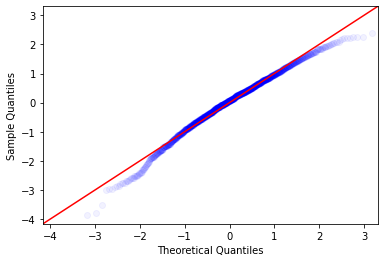

In [175]:
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              7395.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:42:26   Log-Likelihood:                         -14112.
No. Observations:                1201   AIC:                                  2.825e+04
Df Residuals:                    1187   BIC:                                  2.832e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       5516.5803   1808.047      3.051      0.002    1969.257    9063.904
lat              1.14e+05   8071.127     14.119      0.000    9.81e+04     1.3e+05
long            4.225e+04   3135.618     13.475      0.000    3.61e+04    4.84e+04
sqft_habitable     0.0196      0.002      8.221      0.000       0.015       0.024
view1           3.119e+04   9370.099      3.328      0.001    1.28e+04    4.96e+04
view2           1.406e+04   5386.845      2.610      0.009    3490.485    2.46e+04
view3           2.716e+04   1.04e+04      2.621      0.009    6829.594    4.75e+04
Cpl              1.03e+04   3304.570      3.117      0.002    3817.932    1.68e+04
Bmin            2.484e+04   4070.133      6.103      0.000    1.69e+04    3.28e+04
B               3.386e+04   1.22e+04      2.780      0.006    9964.777    5.78e+04
Bpl             1.612e-10   6.35e-11      2.540      0.011    3.67e-11    2.86e-10
Amin            3.849e-11   1.42e-11      2.711      0.007    1.06e-11    6.63e-11
zip055t065      1.642e+04   2749.620      5.973      0.000     1.1e+04    2.18e+04
zip092t106      1.426e+04   3813.102      3.741      0.000    6782.612    2.17e+04
zip107t115      2.405e+04   5771.464      4.167      0.000    1.27e+04    3.54e+04
zip146t168      9441.6758   2987.861      3.160      0.002    3579.598    1.53e+04
==============================================================================
Omnibus:                       11.464   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                8.690
Skew:                          -0.104   Prob(JB):                       0.0130
Kurtosis:                       2.639   Cond. No.                     2.01e+23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.82e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

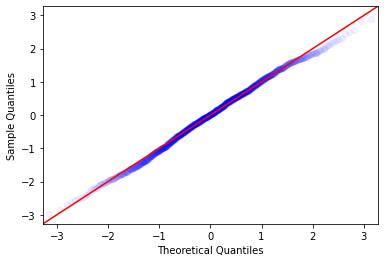

In [176]:
#make_ols(hightier, highincome)
model = make_ols(lowtier, lowincome)

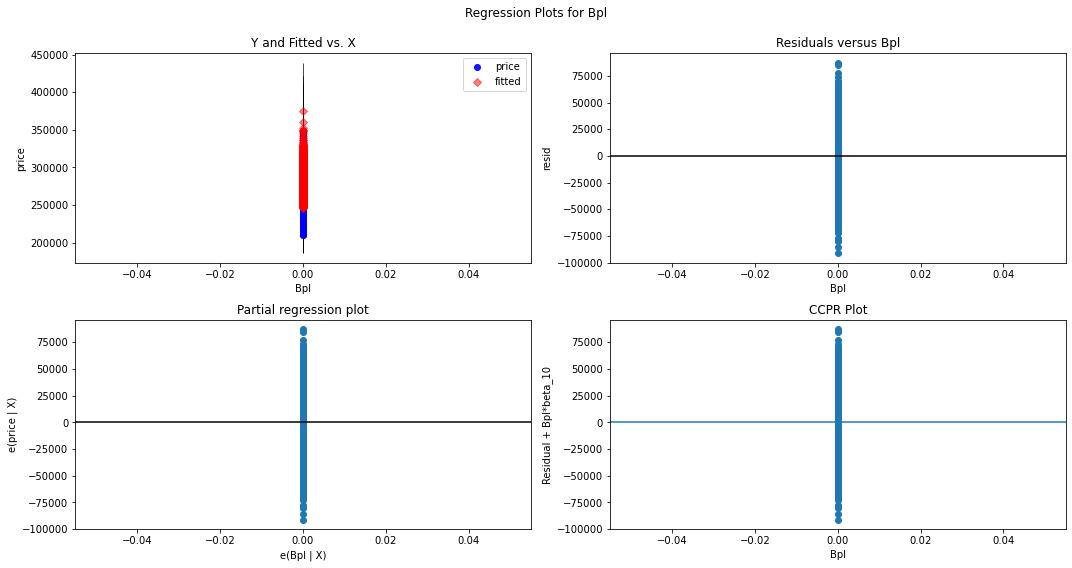

In [80]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "Bpl", fig=fig)
plt.show()

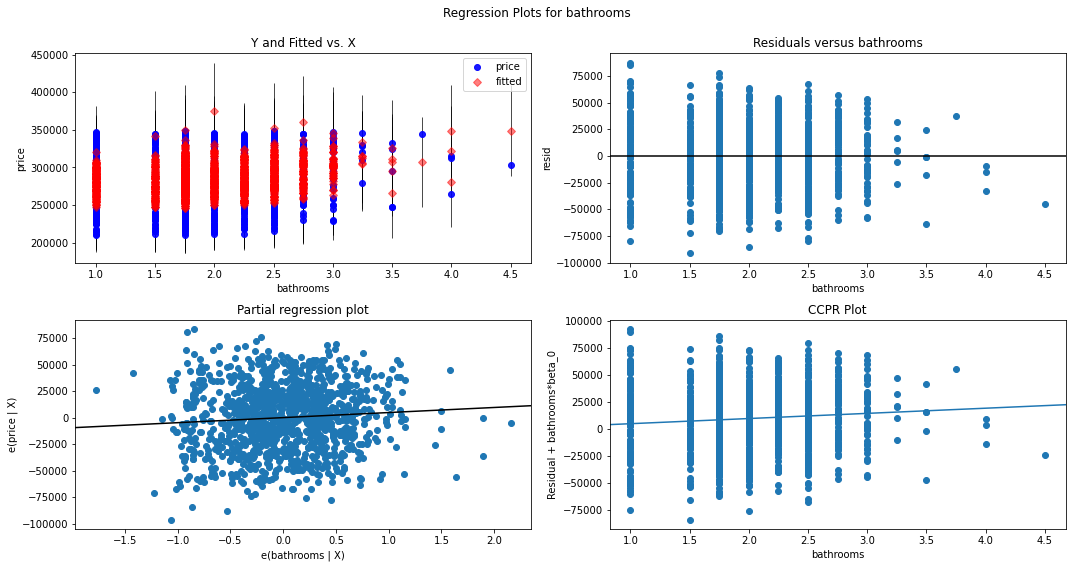

In [44]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

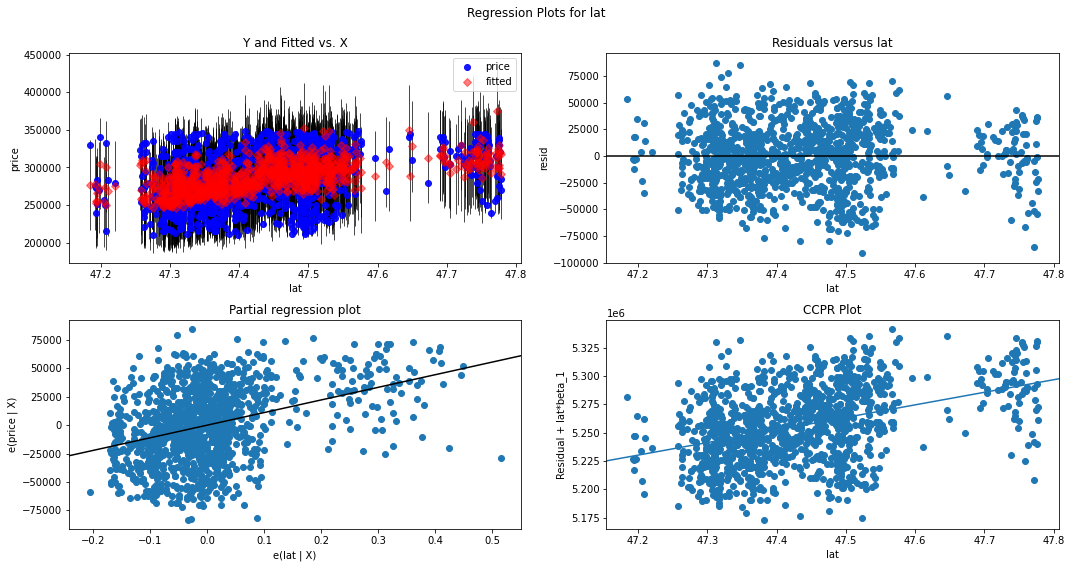

In [45]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "lat", fig=fig)
plt.show()

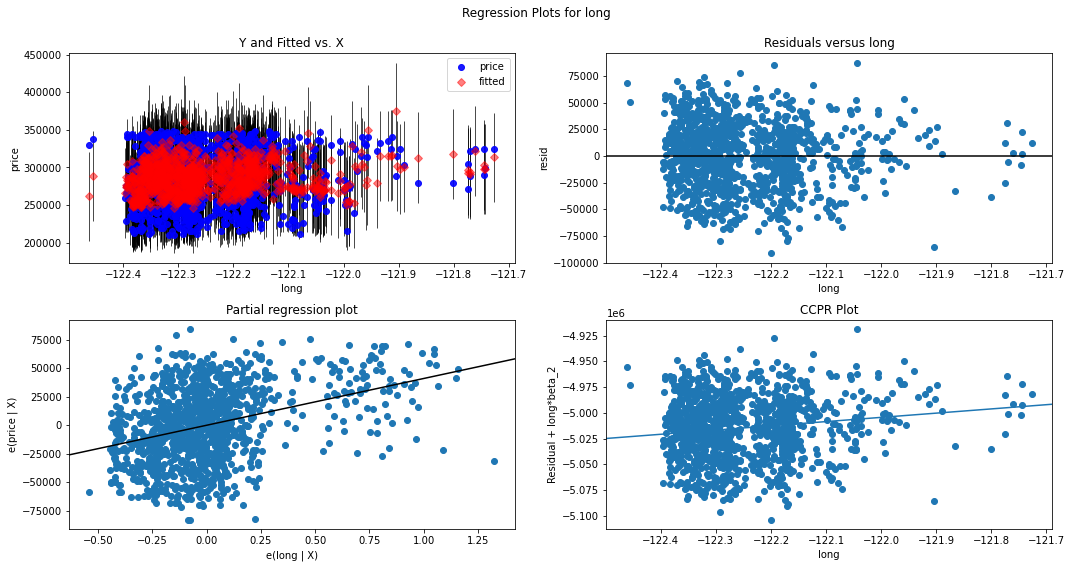

In [46]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "long", fig=fig)
plt.show()

In [47]:
# fig = plt.figure(figsize=(15,8))
# fig = sm.graphics.plot_regress_exog(model, "sqft_total", fig=fig)
# plt.show()
lowtier.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'yr_renovated', 'lat', 'long', 'sqft_total', 'sqft_neighb', 'sqft_habitable', 'good', 'view1', 'view2', 'view3', 'view4', 'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 'zip177t199', 'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80', 'mi_nearest_scl'], dtype='object')

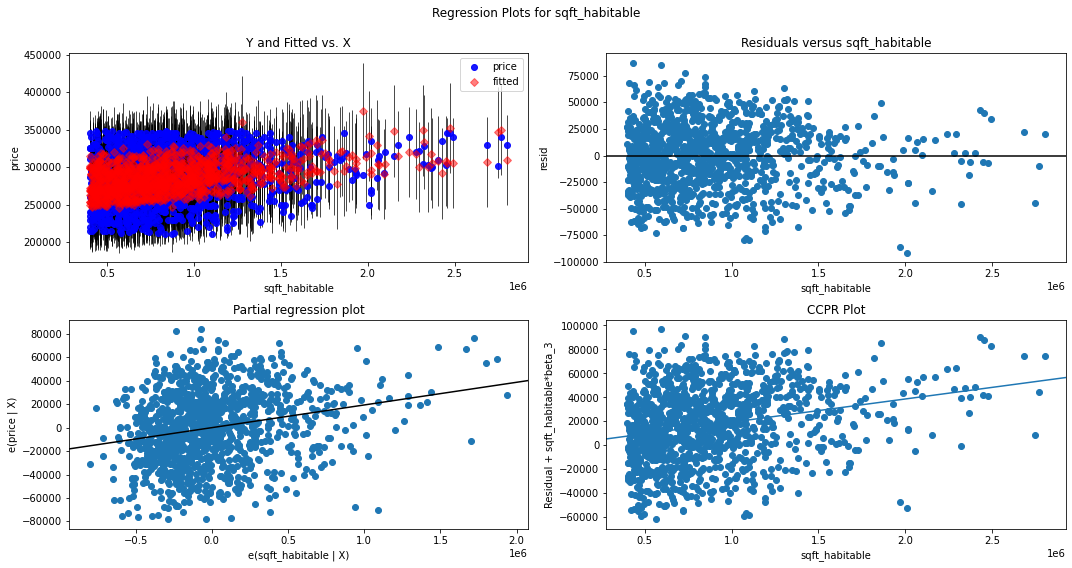

In [48]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_habitable", fig=fig)
plt.show()

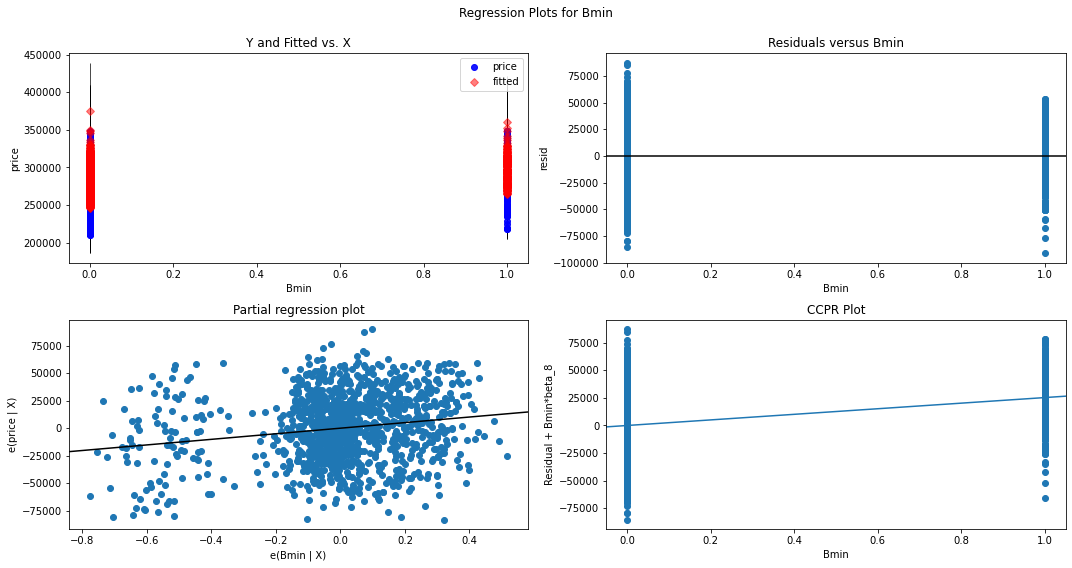

In [49]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "Bmin", fig=fig)
plt.show()

In [50]:
lowtier['sqft_total'].describe()

count    1.190000e+03
mean     2.032889e+07
std      1.847508e+07
min      1.878120e+06
25%      1.273828e+07
50%      1.610518e+07
75%      2.076833e+07
max      1.964556e+08
Name: sqft_total, dtype: float64

## Train Split Test - High Tier

In [177]:
#first step
high_data = hightier[['price', 'bathrooms', 'floors', 'sqft_neighb', 
              'sqft_habitable', 'Amin', 'thru2020',
              'zip006t011', 'zip027t031',  'zip070t077', 
              'zip107t115', 'zip116t122', 'zip177t199']].copy()

training_data, testing_data = train_test_split(high_data, test_size=0.30, random_state=42)

In [178]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              2568.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:44:07   Log-Likelihood:                         -18003.
No. Observations:                1347   AIC:                                  3.603e+04
Df Residuals:                    1335   BIC:                                  3.609e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.641e+05   6929.402     23.687      0.000    1.51e+05    1.78e+05
floors          1.737e+05   1.02e+04     16.997      0.000    1.54e+05    1.94e+05
sqft_neighb        0.0013      0.000      6.776      0.000       0.001       0.002
sqft_habitable     0.0188      0.006      3.237      0.001       0.007       0.030
Amin           -2.428e+05   5.33e+04     -4.553      0.000   -3.47e+05   -1.38e+05
thru2020       -1.784e+05    1.4e+04    -12.754      0.000   -2.06e+05   -1.51e+05
zip006t011      5.498e+04   1.54e+04      3.559      0.000    2.47e+04    8.53e+04
zip027t031      -4.33e+04   2.17e+04     -1.991      0.047    -8.6e+04    -639.515
zip070t077     -3.214e+04   2.22e+04     -1.450      0.147   -7.56e+04    1.13e+04
zip107t115      9.958e+04   1.29e+04      7.720      0.000    7.43e+04    1.25e+05
zip116t122      8.405e+04   1.27e+04      6.626      0.000    5.92e+04    1.09e+05
zip177t199      1.177e+05   1.51e+04      7.785      0.000    8.81e+04    1.47e+05
==============================================================================
Omnibus:                       40.974   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.010
Skew:                          -0.427   Prob(JB):                     2.78e-10
Kurtosis:                       3.234   Cond. No.                     4.12e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

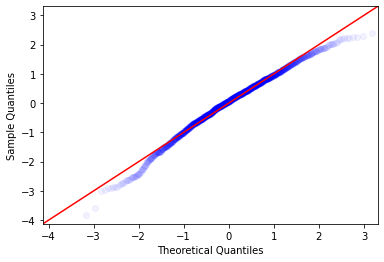

In [181]:
model = make_ols(hightier, predictive_cols)

In [182]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Mean Error', sqrt(train_mse), '\nTesting Mean Error:', sqrt(test_mse))
print(r2_score(training_data[target], y_pred_train))
print(r2_score(testing_data[target], y_pred_test))

Training MSE: 24028915199.54107 
Testing MSE: 23277255424.18148
Training Mean Error 155012.6291614366 
Testing Mean Error: 152568.8546990554
-3.328727726782991
-2.9973594308720615


## Train Split Test - Upper Medium Tier

In [188]:
#first step
upper_med_data = uppermidtier[['price', 'bathrooms', 'long', 'sqft_habitable',
                  'Cpl', 'Bmin', 'B', 'Bpl',
                  'zip014t024', 'zip146t168', 
                  'zip055t065', 'zip125t144', 
                  'thru2000', 'thru2020', 'thru80']].copy()

training_data, testing_data = train_test_split(upper_med_data,test_size=0.25, random_state=42)

In [189]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.416e+04
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:45:14   Log-Likelihood:                         -15058.
No. Observations:                1244   AIC:                                  3.014e+04
Df Residuals:                    1230   BIC:                                  3.022e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       7799.8817   2600.068      3.000      0.003    2698.822    1.29e+04
long           -4152.0460     80.856    -51.351      0.000   -4310.676   -3993.416
sqft_habitable     0.0070      0.002      3.170      0.002       0.003       0.011
Cpl             3.001e+04   9070.515      3.308      0.001    1.22e+04    4.78e+04
Bmin            4.477e+04   9337.206      4.795      0.000    2.65e+04    6.31e+04
B               4.691e+04   1.09e+04      4.315      0.000    2.56e+04    6.82e+04
Bpl             4.885e+04   1.55e+04      3.153      0.002    1.85e+04    7.92e+04
zip014t024     -2.606e+04   1.13e+04     -2.306      0.021   -4.82e+04   -3887.419
zip146t168     -1.831e+04   5906.373     -3.100      0.002   -2.99e+04   -6720.561
zip055t065     -2041.4824   6874.388     -0.297      0.767   -1.55e+04    1.14e+04
zip125t144     -9152.7439   4095.424     -2.235      0.026   -1.72e+04   -1117.954
thru2000       -2.478e+04   4394.120     -5.640      0.000   -3.34e+04   -1.62e+04
thru2020       -2.001e+04   5734.138     -3.490      0.000   -3.13e+04   -8763.801
thru80         -2.208e+04   3236.513     -6.821      0.000   -2.84e+04   -1.57e+04
==============================================================================
Omnibus:                      189.605   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.704
Skew:                           0.067   Prob(JB):                     1.19e-10
Kurtosis:                       2.071   Cond. No.                     2.22e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

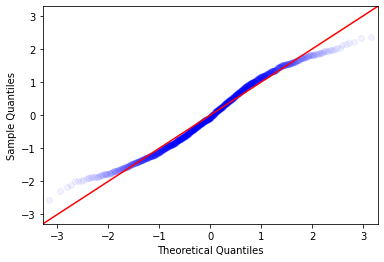

In [190]:
model = make_ols(training_data, predictive_cols)

In [191]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Mean Error', sqrt(train_mse), '\nTesting Mean Error:', sqrt(test_mse))
print(r2_score(training_data[target], y_pred_train))
print(r2_score(testing_data[target], y_pred_test))

Training MSE: 1911314134.6495075 
Testing MSE: 1965782159.0672681
Training Mean Error 43718.57882696448 
Testing Mean Error: 44337.1419812697
0.08419513826885994
0.08048922093448829


## Train Split Test - Medium Tier

In [192]:
#first step
mid_data = midtier[['bathrooms', 'waterfront',  'lat', 'long', 
                'view2', 'Bmin', 'B', 'Bpl', 'Amin', 'price',
                'zip006t011', 'zip032t039', 'zip040t053', 
                'zip070t077',  'zip107t115', 'zip116t122', 
                'zip125t144', 'thru2000', 'thru60', 'thru80']].copy()
training_data, testing_data = train_test_split(mid_data, test_size=0.25, random_state=42)

In [193]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.198e+04
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:46:07   Log-Likelihood:                         -18244.
No. Observations:                1535   AIC:                                  3.652e+04
Df Residuals:                    1517   BIC:                                  3.662e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms   7202.7969   1837.531      3.920      0.000    3598.426    1.08e+04
waterfront -3.117e+04   2.57e+04     -1.213      0.225   -8.16e+04    1.92e+04
lat         7.742e+04   7828.129      9.889      0.000    6.21e+04    9.28e+04
long        2.689e+04   3050.311      8.817      0.000    2.09e+04    3.29e+04
view2        1.74e+04   4430.750      3.926      0.000    8705.754    2.61e+04
Bmin        1.449e+04   2171.420      6.673      0.000    1.02e+04    1.87e+04
B           3.034e+04   5787.819      5.242      0.000     1.9e+04    4.17e+04
Bpl         5.157e+04   1.08e+04      4.775      0.000    3.04e+04    7.28e+04
Amin       -2.966e-12   9.53e-12     -0.311      0.756   -2.17e-11    1.57e-11
zip006t011  2.456e+04   4219.191      5.822      0.000    1.63e+04    3.28e+04
zip032t039  2.096e+04   3420.922      6.128      0.000    1.43e+04    2.77e+04
zip040t053  1.291e+04   4656.643      2.773      0.006    3780.557     2.2e+04
zip070t077  1.655e+04   4468.348      3.703      0.000    7783.302    2.53e+04
zip107t115  1.269e+04   4331.565      2.930      0.003    4195.876    2.12e+04
zip116t122    1.4e+04   3605.082      3.885      0.000    6932.603    2.11e+04
zip125t144  7948.2027   2639.354      3.011      0.003    2771.033    1.31e+04
thru2000   -1.393e+04   3296.056     -4.227      0.000   -2.04e+04   -7466.402
thru60     -3791.7952   2869.622     -1.321      0.187   -9420.643    1837.052
thru80     -1.407e+04   2727.954     -5.157      0.000   -1.94e+04   -8715.778
==============================================================================
Omnibus:                      116.829   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.825
Skew:                          -0.088   Prob(JB):                     1.36e-09
Kurtosis:                       2.221   Cond. No.                     2.08e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.08e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

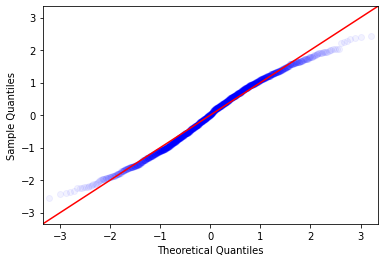

In [194]:
model = make_ols(mid_data, predictive_cols)

In [195]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Mean Error', sqrt(train_mse), '\nTesting Mean Error:', sqrt(test_mse))
print(r2_score(training_data[target], y_pred_train))
print(r2_score(testing_data[target], y_pred_test))

Training MSE: 1277453910.3472266 
Testing MSE: 1103037083.1197984
Training Mean Error 35741.48724307967 
Testing Mean Error: 33212.002094420604
0.15049733778934193
0.21722914791736658


## Train Split Test - Low Tier

In [200]:
#first step
low_data = lowtier[['bathrooms', 'lat', 'long',  'sqft_habitable', 
             'view1', 'view2', 'view3', 'Cpl', 'Bmin', 'B', 
             'Bpl', 'Amin', 'zip055t065', 'zip092t106', 'price',
             'zip107t115', 'zip116t122', 'zip146t168']].copy()

training_data, testing_data = train_test_split(low_data, test_size=0.25, random_state=42)

In [201]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              6904.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):                        0.00
Time:                        22:47:01   Log-Likelihood:                         -14111.
No. Observations:                1201   AIC:                                  2.825e+04
Df Residuals:                    1186   BIC:                                  2.833e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       5581.1141   1808.786      3.086      0.002    2032.337    9129.891
lat             1.123e+05   8198.987     13.702      0.000    9.63e+04    1.28e+05
long            4.163e+04   3184.169     13.075      0.000    3.54e+04    4.79e+04
sqft_habitable     0.0195      0.002      8.186      0.000       0.015       0.024
view1           3.094e+04   9371.636      3.302      0.001    1.26e+04    4.93e+04
view2           1.411e+04   5386.502      2.620      0.009    3544.335    2.47e+04
view3           2.736e+04   1.04e+04      2.639      0.008    7021.213    4.77e+04
Cpl             1.065e+04   3318.838      3.208      0.001    4136.897    1.72e+04
Bmin            2.531e+04   4090.989      6.186      0.000    1.73e+04    3.33e+04
B               3.449e+04   1.22e+04      2.829      0.005    1.06e+04    5.84e+04
Bpl            -1.184e-11    3.2e-12     -3.702      0.000   -1.81e-11   -5.56e-12
Amin            4.402e-11    3.7e-12     11.908      0.000    3.68e-11    5.13e-11
zip055t065      1.689e+04   2780.914      6.073      0.000    1.14e+04    2.23e+04
zip092t106      1.463e+04   3826.977      3.823      0.000    7123.668    2.21e+04
zip107t115      2.468e+04   5798.155      4.256      0.000    1.33e+04    3.61e+04
zip116t122      5229.2144   4687.778      1.115      0.265   -3968.047    1.44e+04
zip146t168      9969.4686   3024.788      3.296      0.001    4034.936    1.59e+04
==============================================================================
Omnibus:                       11.365   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                8.849
Skew:                          -0.115   Prob(JB):                       0.0120
Kurtosis:                       2.648   Cond. No.                     3.11e+23
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.17e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

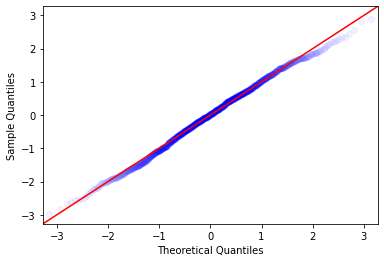

In [202]:
model = make_ols(low_data, predictive_cols)

In [203]:
# predictions
y_pred_train = model.predict(training_data[predictive_cols])
y_pred_test = model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Mean Error', sqrt(train_mse), '\nTesting Mean Error:', sqrt(test_mse))
print(r2_score(training_data[target], y_pred_train))
print(r2_score(testing_data[target], y_pred_test))

Training MSE: 963284037.9926088 
Testing MSE: 868001774.7071315
Training Mean Error 31036.81745915017 
Testing Mean Error: 29461.869844039626
0.27153609781359034
0.34926411816661784


# INTERPRET

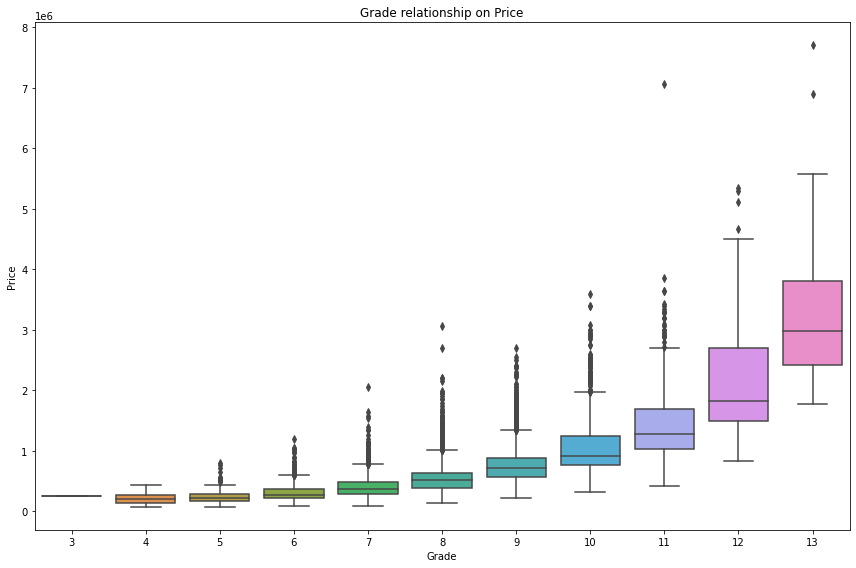

In [67]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='grade', y='price', data=all_data)
ax.set(title='Grade relationship on Price', 
       xlabel='Grade', ylabel='Price')

fig.tight_layout()

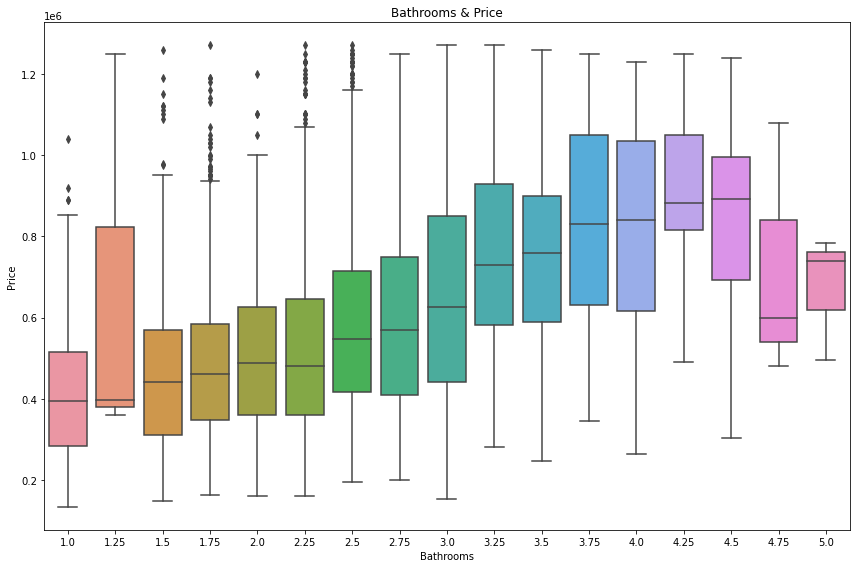

In [68]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bathrooms', y='price', data=kc_data)
ax.set(title='Bathrooms & Price', 
       xlabel='Bathrooms', ylabel='Price')

fig.tight_layout()

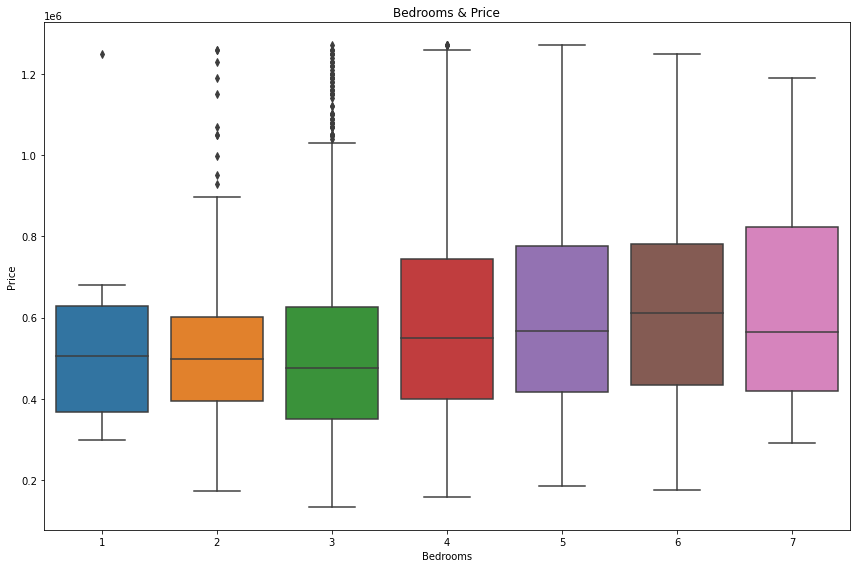

In [69]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='bedrooms', y='price', data=kc_data)
ax.set(title='Bedrooms & Price', 
       xlabel='Bedrooms', ylabel='Price')

fig.tight_layout()

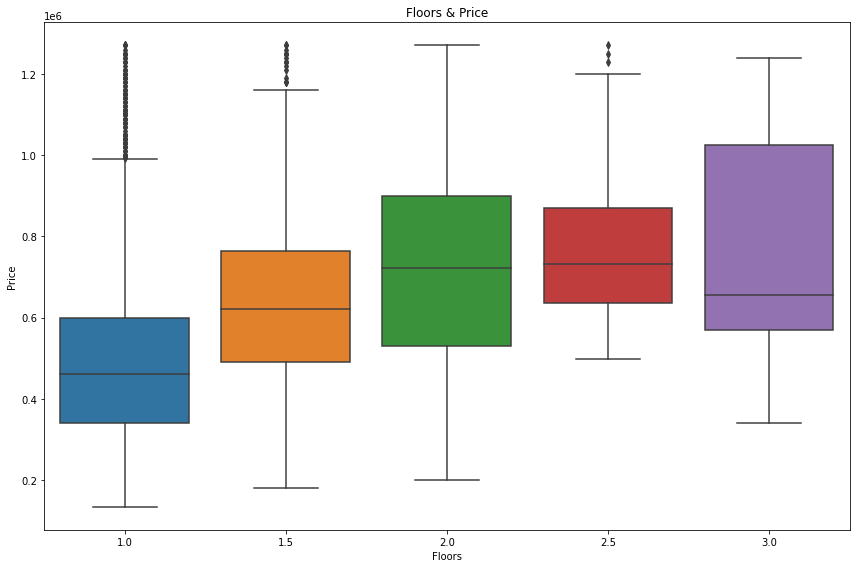

In [70]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='floors', y='price', data=kc_data)
ax.set(title='Floors & Price', 
       xlabel='Floors', ylabel='Price')

fig.tight_layout()

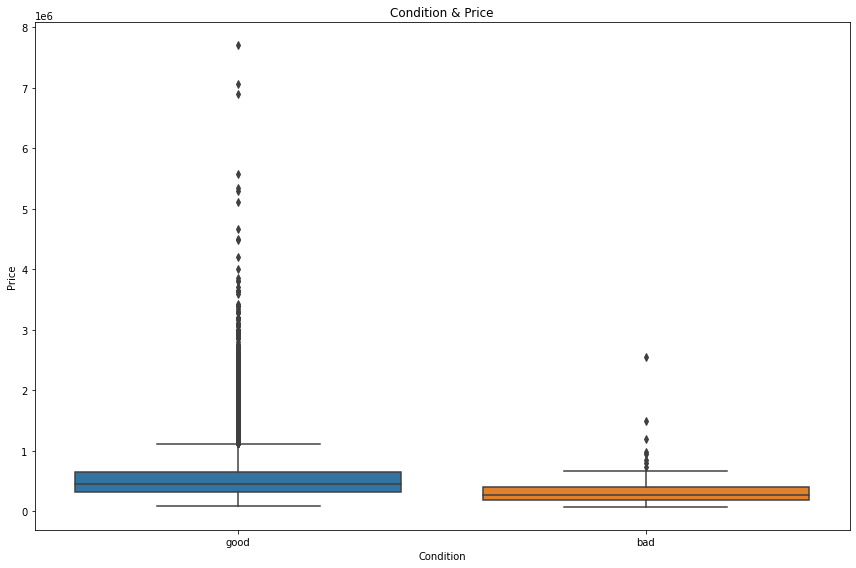

In [71]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='condition', y='price', data=all_data)
ax.set(title='Condition & Price', 
       xlabel='Condition', ylabel='Price')

fig.tight_layout()

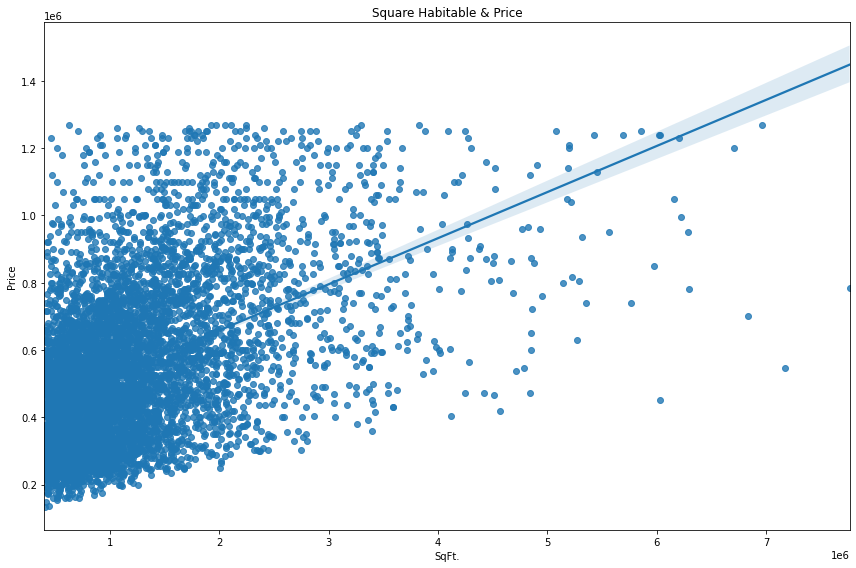

In [72]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='sqft_habitable', y='price', data=kc_data)
ax.set(title='Square Habitable & Price', 
       xlabel='SqFt.', ylabel='Price')

fig.tight_layout()

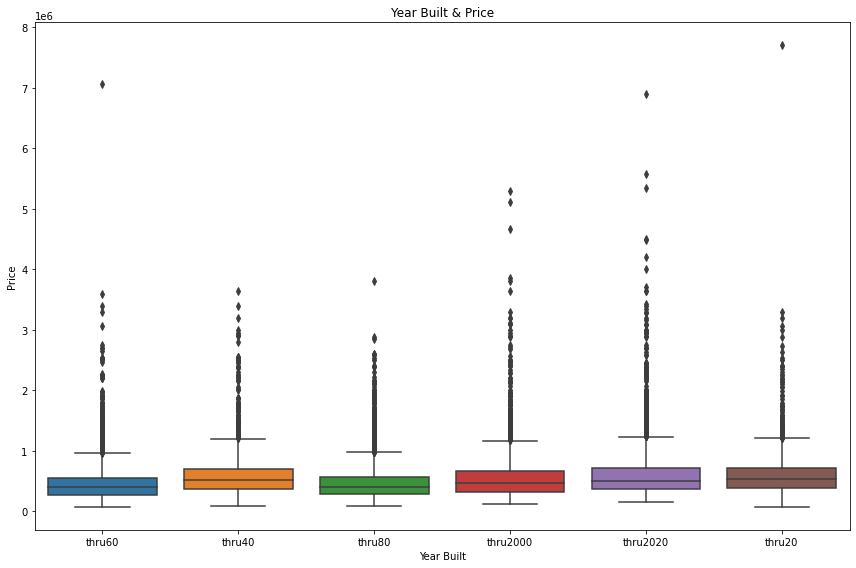

In [73]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_built', y='price', data=all_data)
ax.set(title='Year Built & Price', 
       xlabel='Year Built', ylabel='Price')

fig.tight_layout()

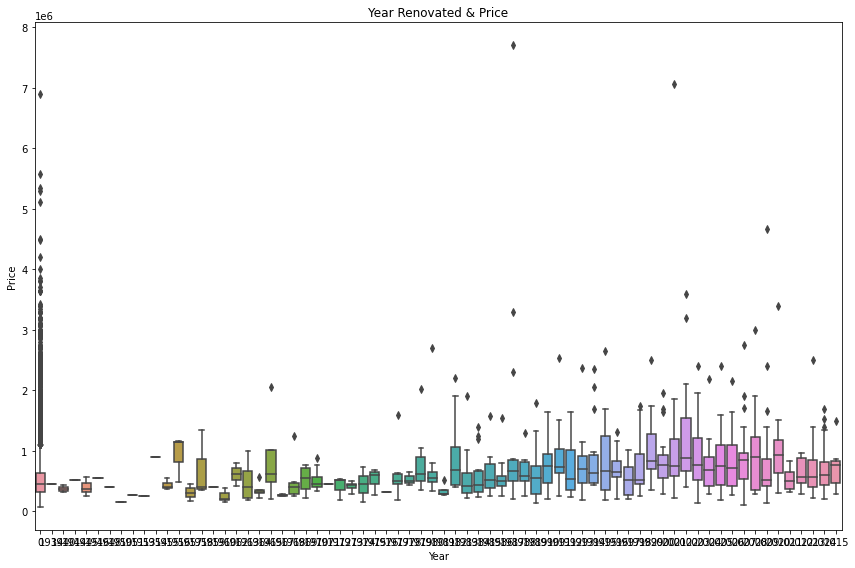

In [74]:
fig, ax = plt.subplots(figsize=(12,8))

sns.boxplot(x='yr_renovated', y='price', data=all_data)
ax.set(title='Year Renovated & Price', 
       xlabel='Year', ylabel='Price')

fig.tight_layout()

## Conclusions & Recommendations

conclusion:
distance to schools? doesn't play a factor until you're in the higher price ranges, if you're a family looking in a low/medium price range, you can aim to be closer to schools without it affecting how much you'll be paying
location location location 